In [1]:
import pandas as pd
import numpy as np
import string
import unicodedata
import os
import glob
import nltk
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
from nltk.probability import FreqDist
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

Ingest Review Text Files

In [3]:
raw_revs = load_files(r'/Users/nicholasbright/Documents/coding/Galvanize/DS-34/repos/capstones/movie_reviews/aclImdb/train', categories=['neg','pos'])

In [4]:
X, y = raw_revs.data, raw_revs.target

Cleaning and Tokenizing

In [5]:
reviews = []
stemmer = WordNetLemmatizer()
for sen in range(0, len(X)):
    # Remove special characters
    review = re.sub(r'\W', ' ', str(X[sen]))
    # Remove single characters
    review = re.sub(r'\s+[a-zA-Z]\s+', ' ', review)
    # Remove single characters from the start
    review = re.sub(r'\^[a-zA-Z]\s+', ' ', review) 
    # Substituting single spaces
    review = re.sub(r'\s+', ' ', review, flags=re.I)
    # Removing prefix 'b'
    review = re.sub(r'^b\s+', '', review)
    # Lowercasing
    review = review.lower()
    # Lemmatize
    review = review.split()
    # Stemming
    review = [stemmer.lemmatize(word) for word in review]
    review = ' '.join(review)
    reviews.append(review)

Bag of Words

In [6]:
stopwords_ = set(stopwords.words('english'))
stopwords_.add("'s")
stopwords_.add('br')
stopwords_.add("'re")
stopwords_.add("n't")
stopwords_.add('ii')
stopwords_.add('iii')
stopwords_.add('iv')
stopwords_.add("'ve")
stopwords_.add("'a")

In [80]:
# CountVectorizer Params: max_features=1000, min_df=0.8, max_df=0.2 , stop_words=stopwords_, ngram_range=(1,2)or(1,3)), max_df=0.9, min_df=0.1
#vec2rizer = CountVectorizer(max_features=10000, min_df=0.025, stop_words=stopwords_)
vectorizer = CountVectorizer(max_features=None, stop_words=stopwords_)
#X = vec2rizer.fit_transform(reviews).toarray()
X = vectorizer.fit_transform(reviews).toarray()

Converting to TFIDF

In [81]:
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

Splitting into Testing and Training Sets

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Creating a Logistic Regression Model

In [83]:
log_reg = LogisticRegression().fit(X_train, y_train)
lr_pred = log_reg.predict(X_test)

In [84]:
print('Classification Report:\n ',classification_report(y_test,lr_pred))
print('Accuracy Score:\n ',accuracy_score(y_test, lr_pred))

Classification Report:
                precision    recall  f1-score   support

           0       0.89      0.87      0.88      2429
           1       0.88      0.90      0.89      2571

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

Accuracy Score:
  0.886


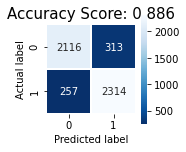

In [85]:
lr_cm = confusion_matrix(y_test,lr_pred)
lr_score = log_reg.score(X_test, y_test)

plt.figure(figsize=(2,2))
sns.heatmap(lr_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(lr_score)
plt.title(all_sample_title, size = 15);

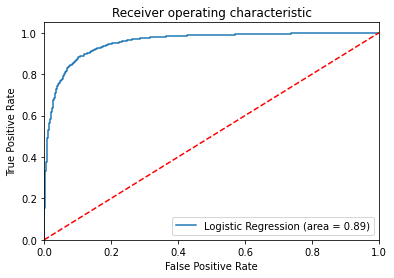

In [86]:
logit_roc_auc = roc_auc_score(y_test, log_reg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Creating a Random Forest Model

In [87]:
rfclassifier = RandomForestClassifier(n_estimators=100)#, random_state=0)
rfclassifier.fit(X_train, y_train) 

RandomForestClassifier()

In [88]:
rf_pred = rfclassifier.predict(X_test)

In [89]:
print('Classification Report:\n ', classification_report(y_test,rf_pred))
print('Accuracy Score:\n ', accuracy_score(y_test, rf_pred))

Classification Report:
                precision    recall  f1-score   support

           0       0.84      0.84      0.84      2429
           1       0.85      0.85      0.85      2571

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000

Accuracy Score:
  0.8458


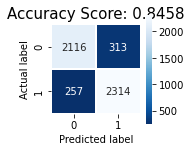

In [90]:
rf_cm = confusion_matrix(y_test,rf_pred)
rf_score = rfclassifier.score(X_test, y_test)

plt.figure(figsize=(2,2))
sns.heatmap(lr_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(rf_score)
plt.title(all_sample_title, size = 15);

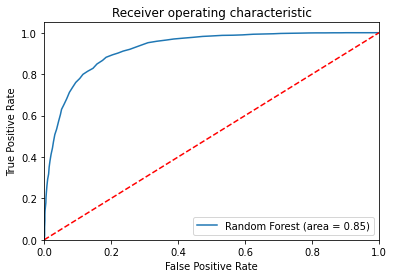

In [91]:
rf_roc_auc = roc_auc_score(y_test, rfclassifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfclassifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

Tuning the Models

In [93]:
pipe = Pipeline([('classifier', RandomForestClassifier())])
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
     'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10, 101, 10)),
    'classifier__max_features' : list(range(6, 32, 5))}
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=None)
best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

Testing the Tuned Models

Importing and Preparing the Testing Data

In [ ]:
test_revs = load_files(r'/Users/nicholasbright/Documents/coding/Galvanize/DS-34/repos/capstones/movie_reviews/aclImdb/test', categories=['neg','pos'])

In [ ]:
X_t, y_t = test_revs.data, test_revs.target

In [ ]:
test_set = []
stemmer = WordNetLemmatizer()
for sen in range(0, len(X_t)):
    review = re.sub(r'\W', ' ', str(X_t[sen]))
    review = re.sub(r'\s+[a-zA-Z]\s+', ' ', review)
    review = re.sub(r'\^[a-zA-Z]\s+', ' ', review) 
    review = re.sub(r'\s+', ' ', review, flags=re.I)
    review = re.sub(r'^b\s+', '', review)
    review = review.lower()
    review = review.split()
    review = [stemmer.lemmatize(word) for word in review]
    review = ' '.join(review)
    test_set.append(review)

In [ ]:
X_t = vectorizer.fit_transform(test_set).toarray()
X_t = tfidfconverter.fit_transform(X_t).toarray()